In [2]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from models import NDS2SAEFactory

In [3]:
max_seq_len = 40
min_seq_len = 20

n_inputs = 2
n_neurons = 100
n_outputs = 1

len_x = 1000
x = np.linspace(0, 150, len_x)
total_start_points = len_x - max_seq_len

batch_count = 0
variables = {'full_batch': 100, 'remain_batch_size': 100}


def generate_samples(time):
    x1 = 2 * np.sin(time)
    x2 = 2 * np.cos(time)
    return x1, x2


def generate_train_samples(batch_size=10):
    # Since we have an unlimited supply of dummy data, technically we can just return final_batch=True
    # However to simulate the actual scenario, we fake having 100 examples and the last batch will return True
    if batch_size is None:
        batch_size = variables['full_batch']
        final_batch = True
    else:
        if batch_size >= variables['remain_batch_size']:
            batch_size = variables['remain_batch_size']
            variables['remain_batch_size'] = variables['full_batch']
            final_batch = True
        else:
            variables['remain_batch_size'] -= batch_size
            final_batch = False

    start_time_idx = np.random.choice(list(range(total_start_points)), batch_size)
    sequence_lens = np.random.choice(list(range(min_seq_len, max_seq_len + 1)), batch_size).astype(np.int32)

    time_axis = [x[t:(t + seq_len)] for t, seq_len in zip(start_time_idx, sequence_lens)]
    input = []
    output = []
    for t in time_axis:
        sin, cos = generate_samples(t)
        input.append(np.array([sin, cos]).transpose(1, 0))
        output.append(np.array([sin + cos]).transpose(1, 0))

    return input, output, final_batch

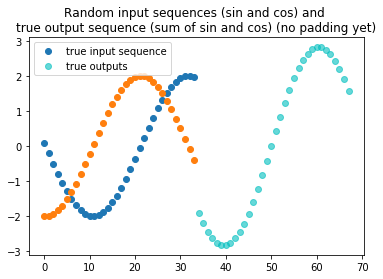

In [11]:
def show_sample():
    test_seq, test_res, _ = generate_train_samples(batch_size=1)
    seq_len = len(test_seq[0])

    plt.title("""Random input sequences (sin and cos) and \ntrue output sequence (sum of sin and cos) (no padding yet)""")
    i = plt.plot(range(seq_len), test_seq[0], 'o', label='true input sequence')
    t = plt.plot(range(seq_len, seq_len + seq_len), test_res[0], 'co', alpha=0.6, label='true outputs')

    plt.legend(handles=[i[0], t[0]], loc='upper left')
    plt.show()

show_sample()

In [4]:
n_iterations = 3000

factory = NDS2SAEFactory()
factory.set_output('toy.zip')
factory.lrtype = 'expdecay'
factory.lrargs = dict(start_lr=0.02, finish_lr=0.00001, decay_steps=n_iterations)
factory.input_dim = n_inputs
factory.output_dim = n_outputs
factory.layer_sizes = [50, 30]
encoder = factory.build()

# If toy.zip exists, the encoder will continue the training
# Otherwise it'll train a new model and save to toy.zip every {display_step}
encoder.train(generate_train_samples, 
              generate_train_samples, # Validation samples are generated in the same was as training samples
              n_iterations=n_iterations, 
              batch_size=50, 
              display_step=100,
              save_step=200
             )

Epoch   0/3000 - Loss: 21.558  - Validation loss:  3.473 - Learning rate: 0.0200000
Epoch 100/3000 - Loss:  0.089  - Validation loss:  0.088 - Learning rate: 0.0155237
Epoch 200/3000 - Loss:  0.075  - Validation loss:  0.095 - Learning rate: 0.0120493
Epoch 300/3000 - Loss:  0.057  - Validation loss:  0.050 - Learning rate: 0.0093525
Epoch 400/3000 - Loss:  0.026  - Validation loss:  0.032 - Learning rate: 0.0072593
Epoch 500/3000 - Loss:  0.010  - Validation loss:  0.010 - Learning rate: 0.0056345
Epoch 600/3000 - Loss:  0.005  - Validation loss:  0.011 - Learning rate: 0.0043734
Epoch 700/3000 - Loss:  0.003  - Validation loss:  0.003 - Learning rate: 0.0033946
Epoch 800/3000 - Loss:  0.002  - Validation loss:  0.002 - Learning rate: 0.0026348
Epoch 900/3000 - Loss:  0.001  - Validation loss:  0.001 - Learning rate: 0.0020451
Epoch 1000/3000 - Loss:  0.001  - Validation loss:  0.001 - Learning rate: 0.0015874
Epoch 1100/3000 - Loss:  0.001  - Validation loss:  0.001 - Learning rate: 

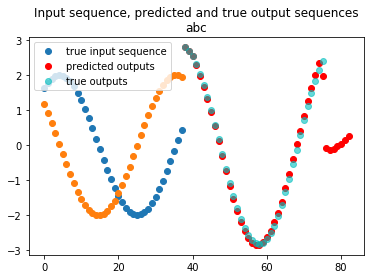

In [6]:
def show_test():
    test_seq, test_res, _ = generate_train_samples(batch_size=50)
    predicted = encoder.predict(test_seq)

    seq_len = len(test_seq[0])
    pre_len = len(predicted[0])

    plt.title("""Input sequence, predicted and true output sequences
    The red dots near 0 of the predicted sequence signify the End Of Sequence""")
    i = plt.plot(range(seq_len), test_seq[0], 'o', label='true input sequence')
    p = plt.plot(range(seq_len, seq_len + pre_len), predicted[0], 'ro', label='predicted outputs')
    t = plt.plot(range(seq_len, seq_len + seq_len), test_res[0], 'co', alpha=0.6, label='true outputs')
    plt.legend(handles=[i[0], p[0], t[0]], loc='upper left')
    plt.show()

# Run this to use the trained autoencoder to encode and decode a randomly generated sequence
# And display them
show_test()

In [7]:
def run_encode():
    init = tf.global_variables_initializer()
    session = tf.Session()
    session.run(init)

    test_seq, test_res, _ = generate_train_samples(batch_size=1)
    
    # If the hidden structure has more than 1 layers, set kernel_only to True to use only the last layer for encoding
    # otherwise all layers will be used and the result is a concatenation of all layers' states
    encoded = encoder.encode(test_seq, session, kernel_only=True)
    session.close()
    print(encoded)

# This will print out the encoded (hidden layers) value
run_encode()

encoder.cleanup()

[[6.1327887e-01 3.0959178e-02 7.8811188e-04 8.9281460e-19 1.4577006e-13
  1.7883739e-01 0.0000000e+00 0.0000000e+00 2.1593392e-01 7.7278189e-02
  1.9580168e-01 5.2883631e-01 1.4626450e-04 0.0000000e+00 1.5987942e-12
  0.0000000e+00 1.4888297e+00 0.0000000e+00 1.6007178e-10 0.0000000e+00
  5.1477516e-01 6.6292828e-01 6.8860820e-05 0.0000000e+00 9.1949970e-02
  0.0000000e+00 6.7564970e-10 4.9262691e-01 1.5913693e-02 5.0580728e-01]]
Cleaned up temp folder /tmp/NDS2SAE-6c81736c18964a3d8624e646758eed2a
